In [ ]:
import sys
import os
import matplotlib.pyplot as plt 
import numpy as np

from data.data_loader import load_nasa_data

data_path = 'B0005.mat' 
results = load_nasa_data(data_path)

print(f"Loaded {len(results)} cycles for analysis.")

Loaded 168 cycles for analysis.


In [4]:
# 3. VISUALIZATION A: Voltage vs Time ("Signal Processing" View)
plt.figure(figsize=(10, 4))
first = discharge_cycles[0]
last = discharge_cycles[-1]
plt.plot(first['time'], first['voltage'], label='Cycle 1 (New Battery)', color='blue')
plt.plot(last['time'], last['voltage'], label=f'Cycle {len(discharge_cycles)} (Aged)', color='red')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.title('Plot A: Voltage Degradation Signal')
plt.legend()
plt.grid(True)
plt.show() 

# 4. VISUALIZATION B: Capacity vs Cycle ("ML Regression" View)
caps = [c['capacity'] for c in discharge_cycles]
plt.figure(figsize=(10, 4))
plt.plot(range(len(caps)), caps, 'go-', markersize=3, label='SOH Trend')
plt.axhline(y=1.4, color='r', linestyle='--', label='EOL Threshold')
plt.ylabel('Capacity (Ah)')
plt.xlabel('Cycle Number')
plt.title('Plot B: Capacity Fade over Life Cycle')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'discharge_cycles' is not defined

<Figure size 1000x400 with 0 Axes>

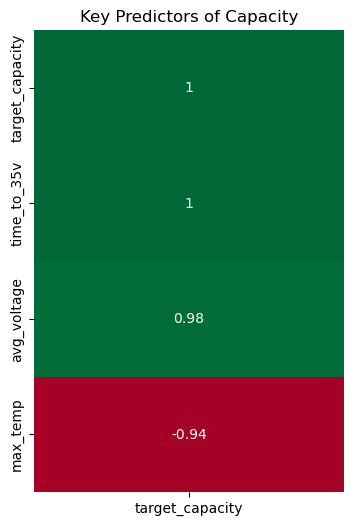

Training Table Preview:
   time_to_35v   max_temp  avg_voltage  target_capacity
0     2058.641  38.982181     3.529829         1.856487
1     2115.688  39.033398     3.537320         1.846327
2     2116.094  38.818797     3.543737         1.835349
3     2135.578  38.762305     3.543666         1.835263
4     2134.516  38.665393     3.542343         1.834646


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

features = []

for cycle in discharge_cycles:
    v = cycle['voltage']
    t = cycle['time']
    temp = cycle['temp']
    
    # Feature 1: Time to reach 3.5V
    try:
        # Find index where voltage first drops below 3.5V
        idx_35 = np.where(v <= 3.5)[0][0]
        t_35 = t[idx_35]
    except IndexError:
        t_35 = t[-1] # Fallback to total discharge time
        
    # Feature 2: Max Temperature
    max_t = np.max(temp)
    
    # Feature 3: Average Voltage (mean level of the curve)
    avg_v = np.mean(v)
    
   # extraction 
    capacity_value = cycle['capacity'].item() if isinstance(cycle['capacity'], np.ndarray) else cycle['capacity']
    
    features.append({
        'time_to_35v': t_35,
        'max_temp': max_t,
        'avg_voltage': avg_v,
        'target_capacity': float(capacity_value)
    })
    # Convert to Pandas DataFrame
df = pd.DataFrame(features)

# Select only the target correlation to make it simpler
target_corr = df.corr()[['target_capacity']].sort_values(by='target_capacity', ascending=False)

plt.figure(figsize=(4, 6))
sns.heatmap(target_corr, annot=True, cmap='RdYlGn', cbar=False)
plt.title('Key Predictors of Capacity')
plt.show()

print("Training Table Preview:")
print(df.head())

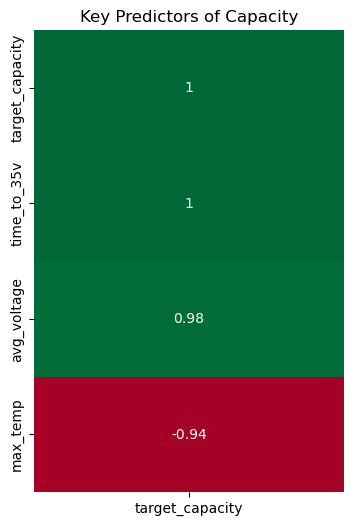

Training Table Preview:
   time_to_35v   max_temp  avg_voltage  target_capacity
0     2058.641  38.982181     3.529829         1.856487
1     2115.688  39.033398     3.537320         1.846327
2     2116.094  38.818797     3.543737         1.835349
3     2135.578  38.762305     3.543666         1.835263
4     2134.516  38.665393     3.542343         1.834646
Model Training Complete. Mean Squared Error: 0.000116


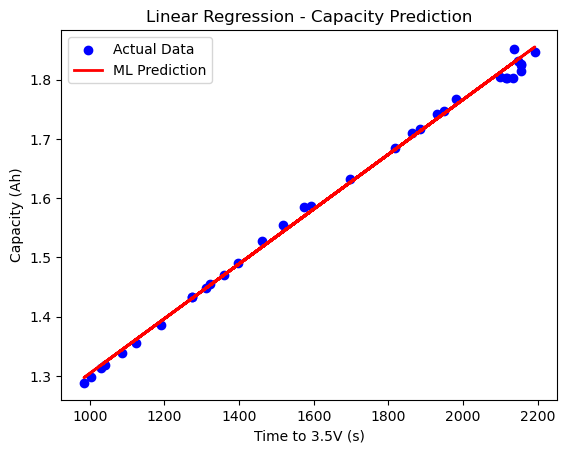

--- Model Evaluation Report ---
Mean Absolute Error: 0.0086 Ah
R2 Score: 0.9968


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Prepare Data
X = df[['time_to_35v']] # best feature
y = df['target_capacity']

# 2. Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict and Evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f"Model Training Complete. Mean Squared Error: {mse:.6f}")

# Visualize the Prediction Line
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, predictions, color='red', linewidth=2, label='ML Prediction')
plt.xlabel('Time to 3.5V (s)')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.title('Linear Regression - Capacity Prediction')
plt.show()

from sklearn.metrics import r2_score, mean_absolute_error

# 1. Calculate advanced metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"--- Model Evaluation Report ---")
print(f"Mean Absolute Error: {mae:.4f} Ah")
print(f"R2 Score: {r2:.4f}")

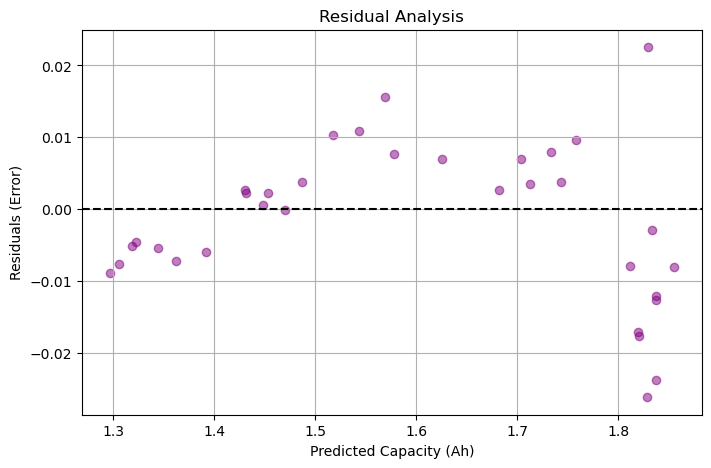

In [ ]:
# 2. Residual Plot
residuals = y_test - predictions
plt.figure(figsize=(8, 5))
plt.scatter(predictions, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Capacity (Ah)')
plt.ylabel('Residuals (Error)')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()